<a href="https://colab.research.google.com/github/dylanbforde/Cardiac-MRI-Segmentation/blob/DataLoading/Augmented_data_loaders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Augmented_data_loaders

In [3]:
!pip install torchio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.2/193.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
from pathlib import Path
from torch.utils.data import DataLoader
import torchio as tio
import numpy as np
import torch


In [11]:
def get_subjects(image_dir, label_dir):
    image_paths = sorted(image_dir.glob('*.nii.gz'))
    label_paths = sorted(label_dir.glob('*.nii.gz'))
    assert len(image_paths) == len(label_paths)

    subjects = []
    for img_path, lbl_path in zip(image_paths, label_paths):
        subject = tio.Subject(
            mri=tio.ScalarImage(img_path),
            heart=tio.LabelMap(lbl_path)
        )
        subjects.append(subject)
    return subjects

In [12]:
def get_loaders(modality='SA', base_path='/content/drive/Shareddrives/Segmentation Data Split/processed_data', batch_size=4, num_workers=4,
                patch_size=(256, 256, 1), augment=True):

    assert modality in ['SA', 'LA'], "Modality must be 'SA' or 'LA'"

    base_path = Path(base_path)
    paths = {
        'train': {
            'images': base_path / 'train' / modality / 'images',
            'labels': base_path / 'train' / modality / 'labels',
        },
        'val': {
            'images': base_path / 'val' / modality / 'images',
            'labels': base_path / 'val' / modality / 'labels',
        },
        'test': {
            'images': base_path / 'test' / modality / 'images',
            'labels': base_path / 'test' / modality / 'labels',
        }
    }

    # Torchio has some swanky looking transforms - these ones look good can add more?
    # Can find more here: https://docs.torchio.org/transforms/transforms.html
    common_transforms = [
        tio.CropOrPad(patch_size),
        tio.ZNormalization(masking_method=tio.ZNormalization.mean),
        tio.RescaleIntensity(out_min_max=(0, 1)),
    ]

    augment_transforms = [
        tio.RandomFlip(axes=(0, 1), flip_probability=0.5),
        tio.RandomAffine(scales=(0.9, 1.1), degrees=10),
        tio.RandomNoise(mean=0.0, std=0.01),
        tio.RandomBlur(std=(0.1, 1.0)),
    ] if augment else []

    training_transform = tio.Compose(common_transforms + augment_transforms)
    validation_transform = tio.Compose(common_transforms)


    train_subjects = get_subjects(paths['train']['images'], paths['train']['labels'])
    val_subjects = get_subjects(paths['val']['images'], paths['val']['labels'])
    test_subjects = get_subjects(paths['test']['images'], paths['test']['labels'])

    train_dataset = tio.SubjectsDataset(train_subjects, transform=training_transform)
    val_dataset = tio.SubjectsDataset(val_subjects, transform=validation_transform)
    test_dataset = tio.SubjectsDataset(test_subjects, transform=validation_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    print("Done")

    return train_loader, val_loader, test_loader

In [14]:
train_loader, val_loader, test_loader = get_loaders(
    modality='SA',
    base_path='/content/drive/Shareddrives/Segmentation Data Split/processed_data',
    batch_size=2,
    num_workers=0,
    patch_size=(256, 256,1),
    augment=True
)

Done


Images shape: torch.Size([2, 1, 256, 256, 1])
Labels shape: torch.Size([2, 1, 256, 256, 1])
Subject keys: dict_keys(['mri', 'heart'])


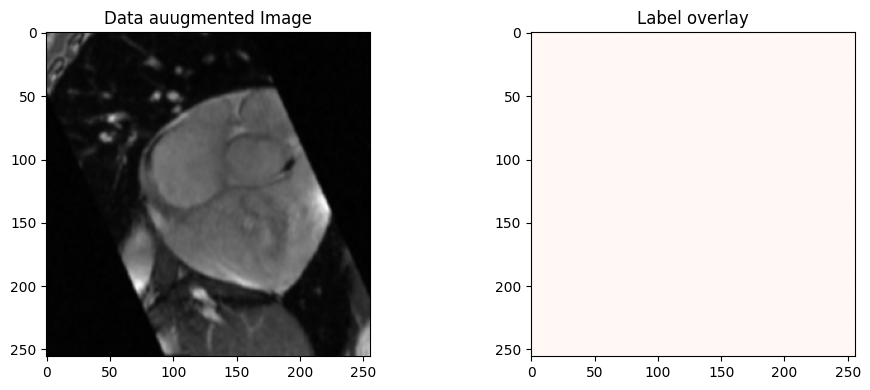

In [15]:
# This just tests it on a single batch to make sure everthing works

import matplotlib.pyplot as plt

batch = next(iter(train_loader))
images = batch['mri'][tio.DATA]
labels = batch['heart'][tio.DATA]

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Subject keys: {batch.keys()}")

img_slice = images[0, 0, :, :, 0].numpy()
lbl_slice = labels[0, 0, :, :, 0].numpy()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_slice, cmap='gray')
plt.title("Data auugmented Image")

plt.subplot(1, 2, 2)
plt.imshow(lbl_slice, cmap='Reds', alpha=0.7)
plt.title("Label overlay")

plt.tight_layout()
plt.show()

## Model

In [ ]:
### Tutorial model example
import torch
from torch import nn

from collections import OrderedDict

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=4, init_features=32):
        super(UNet, self).__init__()

        features = init_features

        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        out = self.conv(dec1)

        return out

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),

                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True))

                ]
            )
        )

In [37]:
###################################
#      3D SegFormer Model
###################################

import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.layers import DropPath

# 1. Overlapping Patch Embedding (3D)
class OverlapPatchEmbed3D(nn.Module):
    """
    Splits the input 3D volume into overlapping patches via a Conv3d layer
    and projects them into a token embedding space, followed by LayerNorm.
    """
    def __init__(self, img_size, patch_size, stride, in_chans, embed_dim):
        super().__init__()
        # img_size: (D, H, W), patch_size: (pD, pH, pW), stride: (sD, sH, sW)
        padding = tuple(p // 2 for p in patch_size)
        # 3D convolution to extract patch embeddings
        self.proj = nn.Conv3d(in_chans, embed_dim,
                              kernel_size=patch_size,
                              stride=stride,
                              padding=padding)
        # Layer normalization on the channel dimension
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape [B, C, D, H, W]
        Returns:
            tokens: Tensor of shape [B, N, embed_dim], where N = D'*H'*W'
            spatial_dims: Tuple (D', H', W') after projection
        """
        x = self.proj(x)  # [B, embed_dim, D', H', W']
        B, C, D, H, W = x.shape
        # flatten spatial dims, to [B, N, C]
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x, (D, H, W)

# 2. Transformer Encoder Block
class TransformerBlock(nn.Module):
    """
    A single Transformer block: LayerNorm -> MHSA -> residual -> MLP -> residual.
    Supports stochastic depth via DropPath.
    """
    def __init__(self, dim, num_heads, mlp_ratio=4.0,
                 qkv_bias=True, drop=0.0, attn_drop=0.0, drop_path=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads,
                                          dropout=attn_drop,
                                          bias=qkv_bias)
         # DropPath for stochastic depth regularization
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        # MLP with two linear layers and a GELU activation
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(drop)
        )

    def forward(self, x, xyz):
        """
        Args:
            x: Tensor of shape [B, N, C]
            xyz: Spatial dimensions tuple (D, H, W), unused here
        Returns:
            Tensor of shape [B, N, C]
        """
        B, N, C = x.size()
        shortcut = x
        x = self.norm1(x)
        x = x.transpose(0, 1) # MHSA expects sequence-first format [N, B, C]
        x, _ = self.attn(x, x, x)
        x = x.transpose(0, 1)
        x = shortcut + self.drop_path(x) # Residual connection + stochastic depth
        x = x + self.drop_path(self.mlp(self.norm2(x))) # MLP with residual and drop path
        return x

# 3. MiT‑backbone for 3D
class MixTransformer3D(nn.Module):
    """
    Hierarchical Vision Transformer backbone adapted for 3D volumes.
    Consists of multiple stages with overlapping patch embeddings and Transformer blocks.
    """
    def __init__(self,
                 img_size=(1, 256, 256),
                 in_chans=1,
                 embed_dims=[64, 128, 320, 512],
                 num_heads=[1, 2, 5, 8],
                 mlp_ratios=[4, 4, 4, 4],
                 depths=[3, 4, 6, 3],
                 drop_path_rate=0.1):
        super().__init__()
        # Compute drop path schedule across all blocks
        total_blocks = sum(depths)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, total_blocks)]
        cur = 0
        self.stages = nn.ModuleList()
        # Build each stage
        for i in range(len(depths)):
            # Spatial dimensions reduce by patch embed stride
            p_dim = img_size if i == 0 else tuple(max(1, dim // (2 ** i)) for dim in img_size)
            patch_size = (1, 7, 7) if i == 0 else (1, 3, 3)
            stride = (1, 4, 4) if i == 0 else (1, 2, 2)
            # Input channels for this stage
            in_ch = in_chans if i == 0 else embed_dims[i - 1]
            embed_dim = embed_dims[i]

            patch_embed = OverlapPatchEmbed3D(
                img_size=p_dim,
                patch_size=patch_size,
                stride=stride,
                in_chans=in_ch,
                embed_dim=embed_dim
            )
            # Stack Transformer blocks with scheduled drop path
            blocks = nn.ModuleList()
            for j in range(depths[i]):
                blocks.append(
                    TransformerBlock(
                        dim=embed_dim,
                        num_heads=num_heads[i],
                        mlp_ratio=mlp_ratios[i],
                        drop_path=dpr[cur + j]
                    )
                )
            cur += depths[i]
            # Collect stage modules
            self.stages.append(nn.ModuleList([patch_embed, blocks]))

    def forward(self, x):
        """
        Args:
            x: Input volume [B, C, D, H, W]
        Returns:
            features: List of feature maps from each stage, each of shape [B, C_i, D_i, H_i, W_i]
        """
        features = []
        for patch_embed, blocks in self.stages:
            x, (D, H, W) = patch_embed(x) # Apply patch embedding to get tokens
            for blk in blocks: # Process tokens through transformer blocks
                x = blk(x, (D, H, W))
            B, N, C = x.size() # Reshape tokens back into 3D feature map
            feat = x.transpose(1, 2).view(B, C, D, H, W)
            features.append(feat)
            # Use output feature map as input to next stage
            x = feat
        return features

# 4. Decoder for 3D semantic segmentation
class SegFormerDecoder3D(nn.Module):
    """
    Simple MLP-style decoder that projects multi-scale features to a common dimension,
    upsamples them, concatenates, and applies a 1×1 classifier.
    """
    def __init__(self, feature_dims=[64, 128, 320, 512], decoder_dim=256, num_classes=21):
        super().__init__()
        # 1×1×1 convolutions to project each feature map to decoder_dim
        self.proj_layers = nn.ModuleList([
            nn.Conv3d(in_ch, decoder_dim, kernel_size=1)
            for in_ch in feature_dims
        ])
        # Classifier: reduce concatenated features and output num_classes channels
        self.classifier = nn.Sequential(
            nn.Conv3d(decoder_dim * len(feature_dims), decoder_dim, kernel_size=1),
            nn.BatchNorm3d(decoder_dim),
            nn.ReLU(),
            nn.Dropout3d(0.1),
            nn.Conv3d(decoder_dim, num_classes, kernel_size=1)
        )

    def forward(self, features):
        """
        Args:
            features: List of feature tensors from backbone
        Returns:
            logits: Segmentation logits at reduced resolution
        """
        # Determine target spatial resolution from the first feature
        target_size = features[0].shape[2:]
        up_feats = []
        # Project and upsample each feature map
        for feat, proj in zip(features, self.proj_layers):
            f = proj(feat)
            if f.shape[2:] != target_size:
                f = F.interpolate(f, size=target_size, mode='trilinear', align_corners=False)
            up_feats.append(f)
        # Concatenate along channel dimension and classify
        x = torch.cat(up_feats, dim=1)
        return self.classifier(x)

# 5. Full 3D SegFormer
class SegFormer3D(nn.Module):
    """
    Complete SegFormer architecture for 3D volumes: backbone + decoder + final upsampling.
    """
    def __init__(self,
                 img_size=(1, 256, 256),
                 in_chans=1,
                 num_classes=21,
                 decoder_dim=256,
                 **backbone_kwargs):
        super().__init__()
        # Backbone: hierarchical transformer feature extractor
        self.backbone = MixTransformer3D(
            img_size=img_size,
            in_chans=in_chans,
            **backbone_kwargs
        )
        # Decoder: projecting and classifying multi-scale features
        self.decoder = SegFormerDecoder3D(
            feature_dims=backbone_kwargs.get('embed_dims', [64,128,320,512]),
            decoder_dim=decoder_dim,
            num_classes=num_classes
        )

    def forward(self, x):
        """
        Args:
            x: Input tensor [B, C, D, H, W]
        Returns:
            seg_logits: Upsampled segmentation logits [B, num_classes, D, H, W]
        """
        features = self.backbone(x)
        seg = self.decoder(features)
        # Upsample to original resolution
        return F.interpolate(seg, size=x.shape[2:], mode='trilinear', align_corners=False)


In [38]:
model = SegFormer3D(img_size=(256,256,1), in_chans=1, num_classes=3)
model

SegFormer3D(
  (backbone): MixTransformer3D(
    (stages): ModuleList(
      (0): ModuleList(
        (0): OverlapPatchEmbed3D(
          (proj): Conv3d(1, 64, kernel_size=(1, 7, 7), stride=(1, 4, 4), padding=(0, 3, 3))
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): ModuleList(
          (0): TransformerBlock(
            (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (0): Linear(in_features=64, out_features=256, bias=True)
              (1): GELU(approximate='none')
              (2): Linear(in_features=256, out_features=64, bias=True)
              (3): Dropout(p=0.0, inplace=False)
            )
          )
         

In [43]:
from torch.nn.functional import softmax
# ================================
#  Minimal Smoke Test for SegFormer3D
# ================================
# This snippet performs a quick validation of the 3D SegFormer model,
# ensuring that it produces outputs with the correct shape and that
# the predicted class probabilities are properly normalized.

model.eval()
# Generate a synthetic 5D tensor representing a single 3D volume
# Tensor shape: [batch_size, channels, depth, height, width]
# Here: batch_size=1, channels=1 (grayscale), depth=1, height=256, width=256
with torch.no_grad():
    x = torch.randn(1, 1, 1, 256, 256, device=device)
    logits = model(x)

# Verify that the output tensor has the expected dimensions:
#    [batch_size, num_classes, depth, height, width]
# For example, if num_classes=3, we expect: [1, 3, 1, 256, 256]
print("Output shape:", logits.shape)

# Apply softmax along the class dimension to obtain probability maps
#    and confirm that probabilities sum to 1 at each voxel.
probs = softmax(logits, dim=1)       # [1, C, D, H, W]
s = probs.sum(dim=1)                 # [1, D, H, W]
print("Sum per voxel min/max:", s.min().item(), s.max().item())


Output shape: torch.Size([1, 3, 1, 256, 256])
Sum per voxel min/max: 0.9999998807907104 1.0000001192092896


In [46]:
# Model architecture visualisation
!pip install torchinfo
from torchinfo import summary
summary(
    model,
    input_size=(1,1,1,256,256),
    depth=4,
    col_names=('output_size','num_params'))

Layer (type:depth-idx)                                  Output Shape              Param #
SegFormer3D                                             [1, 3, 1, 256, 256]       --
├─MixTransformer3D: 1-1                                 [1, 64, 1, 64, 64]        --
│    └─ModuleList: 2-1                                  --                        --
│    │    └─ModuleList: 3-1                             --                        --
│    │    │    └─OverlapPatchEmbed3D: 4-1               [1, 4096, 64]             3,328
│    │    │    └─ModuleList: 4-2                        --                        149,952
│    │    └─ModuleList: 3-2                             --                        --
│    │    │    └─OverlapPatchEmbed3D: 4-3               [1, 1024, 128]            74,112
│    │    │    └─ModuleList: 4-4                        --                        793,088
│    │    └─ModuleList: 3-3                             --                        --
│    │    │    └─OverlapPatchEmbed3D: 4-5  